In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr
import seaborn as sns

FILTERED_EIDS = [
    '56b57c38-2699-4091-90a8-aba35103155e',
    '7af49c00-63dd-4fed-b2e0-1b3bd945b20b',
    '862ade13-53cd-4221-a3fa-dda8643641f2'
]

In [2]:
def compute_ensemble_stddev(
    df_preds,
    keypoint_ensemble_list,
    scorer_name='standard_scorer'
):
    """
    Parameters
    ----------
    df_ground_truth : List[pd.DataFrame]
        ground truth predictions
    df_preds : List[pd.DataFrame]
        model predictions
    keypoint_ensemble_list : List[str]
        keypoints to include in the analysis

    Returns
    -------
    np.ndarray
        shape (n_frames, n_keypoints)
    """
    # Initial check for NaNs in df_preds
    for i, df in enumerate(df_preds):
        if df.isna().any().any():
            print(f"Warning: NaN values detected in initial DataFrame {i}.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(f"NaN values found at indices: {nan_indices} in columns: {nan_columns}")

    preds = []
    cols_order = None
    for i, df in enumerate(df_preds):

        # Standardize the 'scorer' level
        df = standardize_scorer_level(df, scorer_name)

        # Remove likelihood columns
        cols_to_keep = [
            col for col in df.columns
            if not col[2].endswith('likelihood') and 'zscore' not in col[2]]
        # Keep only columns matching the keypoint_ensemble_list
        cols_to_keep = [col for col in cols_to_keep if col[1] in keypoint_ensemble_list]
        df = df[cols_to_keep]

        # print(f"DataFrame {i} kept columns:", df.columns)

        # Check for NaNs in the DataFrame
        if df.isna().any().any():
            print(f"Warning: NaN values detected in DataFrame {i} after filtering.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(f"NaN values found at indices: {nan_indices} in columns: {nan_columns}")

        # Print the order of the column headers
        if cols_order is None:
            cols_order = df.columns
        else:
            if not (df.columns == cols_order).all():
                print(f"Column order mismatch detected in DataFrame {i}")
                print("Expected order:", cols_order)
                print("Actual order:", df.columns)
                # Ensure bodyparts and coordinates are consistent
                expected_bodyparts_coords = cols_order.droplevel(0).unique()
                actual_bodyparts_coords = df.columns.droplevel(0).unique()
                if not expected_bodyparts_coords.equals(actual_bodyparts_coords):
                    print("Bodyparts and coordinates mismatch detected")
                    print("Expected bodyparts and coordinates:", expected_bodyparts_coords)
                    print("Actual bodyparts and coordinates:", actual_bodyparts_coords)

        # Reshape the DataFrame to the appropriate shape
        try:
            arr = df.to_numpy().reshape(df.shape[0], -1, 2)
        except ValueError as e:
            print(f"Reshape error: {e}")
            print(f"DataFrame shape: {df.shape}")
            print(f"Array shape after reshape attempt: {df.to_numpy().shape}")
            raise

        preds.append(arr[..., None])

    preds = np.concatenate(preds, axis=3)

    # Check for NaNs in preds
    if np.isnan(preds).any():
        print("Warning: NaN values detected in preds array.")
        nan_indices = np.argwhere(np.isnan(preds))
        print(f"NaN values found at indices: {nan_indices}")
    else:
        print("No NaN values detected in preds array.")

    stddevs = np.std(preds, axis=-1).mean(axis=-1)
    # print(f"Stddevs: {stddevs}")
    return stddevs


def standardize_scorer_level(df, new_scorer='standard_scorer'):
    """
    Standardizes the 'scorer' level in the MultiIndex to a common name.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to standardize.
    new_scorer : str
        The new name for the 'scorer' level.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the standardized 'scorer' level.
    """
    df.columns = pd.MultiIndex.from_tuples(
        [(new_scorer, bodypart, coord) for scorer, bodypart, coord in df.columns],
        names=df.columns.names
    )
    return df


def compute_percentiles(arr, std_vals, percentiles):
    num_pts = arr[0]
    vals = []
    prctiles = []
    for p in percentiles:
        v = num_pts * p / 100
        idx = np.argmin(np.abs(arr - v))
        # maybe we don't have enough data
        if idx == len(arr) - 1:
            p_ = arr[idx] / num_pts * 100
        else:
            p_ = p
        vals.append(std_vals[idx])
        prctiles.append(np.round(p_, 2))
    return vals, prctiles


def compute_ensemble_stddev(
    df_preds,
    scorer_name="standard_scorer",
):
    """
    Parameters
    ----------
    df_preds : List[pd.DataFrame]
        model predictions

    Returns
    -------
    np.ndarray
        shape (n_frames, n_keypoints)
    """
    # Initial check for NaNs in df_preds
    for i, df in enumerate(df_preds):
        if df.isna().any().any():
            print(f"Warning: NaN values detected in initial DataFrame {i}.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(
                f"NaN values found at indices: {nan_indices} in columns: {nan_columns}"
            )

    preds = []
    for i, df in enumerate(df_preds):
        # Standardize the 'scorer' level
        df = standardize_scorer_level(df, scorer_name)

        # Remove likelihood columns
        cols_to_keep = [
            col
            for col in df.columns
            if not col[2].endswith("likelihood") and "Unnamed" not in col[2]
        ]
        df = df[cols_to_keep]

        # print(f"DataFrame {i} kept columns:", df.columns)

        # Check for NaNs in the DataFrame
        if df.isna().any().any():
            print(f"Warning: NaN values detected in DataFrame {i} after filtering.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(
                f"NaN values found at indices: {nan_indices} in columns: {nan_columns}"
            )

        # Reshape the DataFrame to the appropriate shape
        try:
            arr = df.to_numpy().reshape(df.shape[0], -1, 2)
        except ValueError as e:
            print(f"Reshape error: {e}")
            print(f"DataFrame shape: {df.shape}")
            print(f"Array shape after reshape attempt: {df.to_numpy().shape}")
            raise

        preds.append(arr[..., None])

    preds = np.concatenate(preds, axis=3)

    # Check for NaNs in preds
    if np.isnan(preds).any():
        print("Warning: NaN values detected in preds array.")
        nan_indices = np.argwhere(np.isnan(preds))
        print(f"NaN values found at indices: {nan_indices}")
    else:
        print("No NaN values detected in preds array.")

    stddevs = np.std(preds, axis=-1).mean(axis=-1)
    # print(f"Stddevs: {stddevs}")
    return stddevs


def standardize_scorer_level(df, new_scorer="standard_scorer"):
    """
    Standardizes the 'scorer' level in the MultiIndex to a common name.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to standardize.
    new_scorer : str
        The new name for the 'scorer' level.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the standardized 'scorer' level.
    """
    df.columns = pd.MultiIndex.from_tuples(
        [(new_scorer, bodypart, coord) for scorer, bodypart, coord in df.columns],
        names=df.columns.names,
    )
    return df


def compute_percentiles(arr, std_vals, percentiles):
    num_pts = arr[0]
    vals = []
    prctiles = []
    for p in percentiles:
        v = num_pts * p / 100
        idx = np.argmin(np.abs(arr - v))
        # maybe we don't have enough data
        if idx == len(arr) - 1:
            p_ = arr[idx] / num_pts * 100
        else:
            p_ = p
        vals.append(std_vals[idx])
        prctiles.append(np.round(p_, 2))
    return vals, prctiles


class Ensemble:
    data_to_plot: dict[str, str]  # Model name to path.
    pred_csv_list: list[str]
    error_csv_list: list[str]
    df_pred_list: list[pd.DataFrame]
    df_error_list: list[pd.DataFrame]
    n_points_dict: dict[str, dict[str, int]]  # Model name -> std_val_inx -> num points
    std_vals: list[float]
    df_w_vars: pd.DataFrame
    df_line2: pd.DataFrame

        
def build_ensemble(ens: Ensemble):
    data_to_plot = ens.data_to_plot
    # define predictions so we can compute ensemble variance
    pred_csv_list = []
    # define model names
    model_names_list = []
    # reformat
    for key, val in data_to_plot.items():
        model_names_list.append(key)
        pred_csv_list.append(Path(val))

    error_csv_list = []
    for p in pred_csv_list:
        p = p.with_stem(p.stem.replace("remapped_", ""))
        p = p.with_stem(p.stem.replace("_new", "") + "_pixel_error_new")
        error_csv_list.append(p)

    # load data
    df_pred_list = []
    df_error_list = []
    for pred_csv, error_csv in zip(pred_csv_list, error_csv_list):
        preds_df = pd.read_csv(pred_csv, header=[0, 1, 2], index_col=0).sort_index()
        # remove eids that are in FILTERED_EIDS
        # any FILTERED_EIDS in preds_df.index, remove the eids
        remove_indices = [i for i in preds_df.index if any(eid in i for eid in FILTERED_EIDS)]
        preds_df = preds_df.drop(remove_indices)
        df_pred_list.append(preds_df)
        df = pd.read_csv(error_csv, header=[0], index_col=0).sort_index()
        remove_indices = [i for i in df.index if any(eid in i for eid in FILTERED_EIDS)]
        df = df.drop(remove_indices)
        if "set" in df.columns:
            df = df.drop(columns=["set"])
        df_error_list.append(df)

    # compute ensemble variance
    ens_stddev = compute_ensemble_stddev(
        df_pred_list,
    )

    # Record pixel errors along with ensemble variances
    df_w_vars = []
    # Dataframe:
    #   Index = {img_path}_{model_name}_{kp}: str
    #   model: str
    #   keypoint: str
    #   pixel_error: float
    #   ens-std: float

    for df_error, df_pred, model_name in zip(
        df_error_list, df_pred_list, model_names_list
    ):
        # Ensure df_error has the same index as df_gt
        assert (df_error.index == df_pred_list[0].index).all()
        assert (df_pred.index == df_pred_list[0].index).all()

        # Calculate total pixel error (sum) for each df_error and print it
        total_pixel_error = df_error.sum().sum()
        print(f"Total pixel error for model {model_name}: {total_pixel_error}")

        for i, kp in enumerate(df_error.columns):
            index = [f"{i}_{model_name}_{kp}" for i in df_error.index]
            df_w_vars.append(
                pd.DataFrame(
                    {
                        "pixel_error": df_error[kp].values,
                        "likelihood": df_pred.loc[
                            :, ("standard_scorer", kp, "likelihood")
                        ].values,
                        "ens-std": ens_stddev[:, i],
                        "ens-std-prctile": [
                            np.sum(ens_stddev < p) / ens_stddev.size
                            for p in ens_stddev[:, i]
                        ],
                        "ens-std-prctile-kp": [
                            np.sum(ens_stddev[:, i] < p) / ens_stddev[:, i].size
                            for p in ens_stddev[:, i]
                        ],
                        "keypoint": kp,
                        "model": model_name,
                    },
                    index=index,
                )
            )

    df_w_vars = pd.concat(df_w_vars)

    std_vals = np.arange(0, 8, 0.2)

    # Dict from [model_name][std_vals_index] to the number of points for that model that were greater than
    # std_vals[std_vals_index].
    n_points_dict = {m: np.nan * np.zeros_like(std_vals) for m in model_names_list}

    # Like df_w_vars but one per std_val
    # Dataframe:
    #   Index = {img_path}_{model_name}_{kp}_{std_val_index}: str
    #   model: str
    #   keypoint: str
    #   pixel_error: float
    #   ens-std: float
    #   n_points: int
    df_line2 = []

    for s, std in enumerate(std_vals):
        # Get all
        df_tmp_ = df_w_vars[df_w_vars["ens-std"] > std]
        for model_name in model_names_list:
            d = df_tmp_[df_tmp_.model == model_name]
            n_points = np.sum(~d["pixel_error"].isna())
            n_points_dict[model_name][s] = n_points
            index = []
            for row, keypoint in zip(d.index, d["keypoint"].to_numpy()):
                index.append(f"{row}_{s}")

            df_line2.append(
                pd.DataFrame(
                    {
                        "ens-std": std,
                        "model": model_name,
                        "pixel_error": d.pixel_error.to_numpy(),
                        "keypoint": d["keypoint"].to_numpy(),
                    },
                    index=index,
                )
            )

    df_line2 = pd.concat(df_line2)
    ens.pred_csv_list = pred_csv_list
    ens.error_csv_list = error_csv_list
    ens.df_pred_list = df_pred_list
    ens.df_error_list = df_error_list
    ens.n_points_dict = n_points_dict
    ens.std_vals = std_vals
    ens.df_w_vars = df_w_vars
    ens.df_line2 = df_line2
    return ens


models = ['vit_cm', 'vit_m', 'vit_mae', 'vit_sam', 'resnet50_animal_ap10k', 'resnet50_contrastive','vitb_imagenet', 'vitb_mv','vitb_sv']
colors = sns.color_palette("husl", len(models))
# Define the color mapping
color_mapping = {k: colors[i] for i, k in enumerate(models)}

# Define litpose save dir
LITPOSE_SAVE_DIR = Path("../outputs").resolve()
print(f"LITPOSE_SAVE_DIR: {LITPOSE_SAVE_DIR}")
print(f"Color mapping: {color_mapping}")

LITPOSE_SAVE_DIR: /scratch/yl6624/Project/multi-view/outputs
Color mapping: {'vit_cm': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'vit_m': (0.8369430560927636, 0.5495828952802333, 0.1952683223448124), 'vit_mae': (0.6430915736746491, 0.6271955086583126, 0.19381135329796756), 'vit_sam': (0.3126890019504329, 0.6928754610296064, 0.1923704830330379), 'resnet50_animal_ap10k': (0.20582072623426667, 0.6842209016721069, 0.5675558225732941), 'resnet50_contrastive': (0.2151139535594307, 0.6700707833028816, 0.7112365203426209), 'vitb_imagenet': (0.23299120924703914, 0.639586552066035, 0.9260706093977744), 'vitb_mv': (0.731751635642941, 0.5128186367840487, 0.9581005178234921), 'vitb_sv': (0.9614880299080136, 0.3909885385134758, 0.8298287106954371)}


Plot Configs

In [3]:
title_fontsize = 20
labels_fontsize = 20
ticks_fontsize=16
line_width = 4
spines_width = 2
fig_width = 6
fig_height = 6


Generate Results for mirror-mouse dataset

This is the results of 100-frame mirror-mouse:
Dataset: mirror-mouse, Mode: Fine-Tune, Train Frame: 100

In [4]:
# views of mirror-mouse-separate
views = ['top', 'bot']

No NaN values detected in preds array.
Total pixel error for model resnet50_animal_ap10k.0: 8525.55971763478
Total pixel error for model resnet50_animal_ap10k.1: 10159.259620906374
Total pixel error for model resnet50_animal_ap10k.2: 12481.729433331368
Total pixel error for model vitb_imagenet.0: 9335.468559857134
Total pixel error for model vitb_imagenet.1: 10587.804556882642
Total pixel error for model vitb_imagenet.2: 8419.217587398562
Total pixel error for model vitb_sv.0: 7931.65664411573
Total pixel error for model vitb_sv.1: 8034.200330386803
Total pixel error for model vitb_sv.2: 8788.997889861366
Total pixel error for model vitb_mv.0: 8103.911155614137
Total pixel error for model vitb_mv.1: 8318.836400035641
Total pixel error for model vitb_mv.2: 8114.135981541571


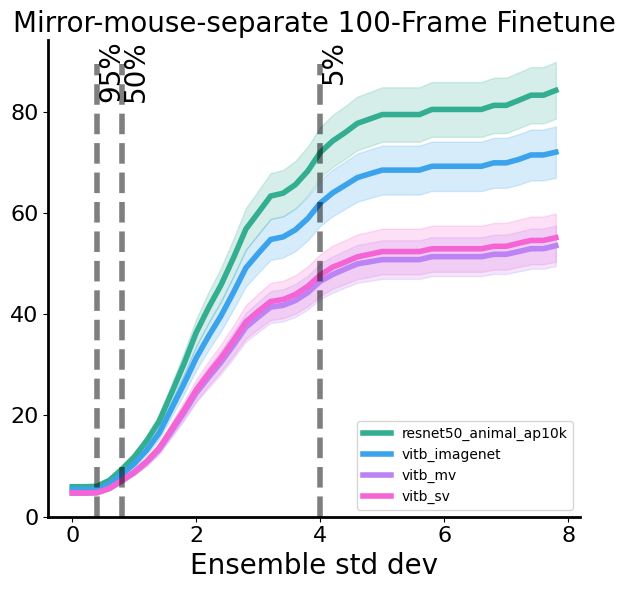

In [5]:
ens = Ensemble()
ens.data_to_plot = {
    # ----------------------
    # resnet50_animal_ap10k
    # ----------------------
    'resnet50_animal_ap10k.0': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-0',
    'resnet50_animal_ap10k.1': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-1',
    'resnet50_animal_ap10k.2': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-2',
    # ----------------------
    # vitb_imagenet
    # ----------------------
    'vitb_imagenet.0': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-vitb_imagenet_frame-100_epoch-300_seed-0',
    'vitb_imagenet.1': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-vitb_imagenet_frame-100_epoch-300_seed-1',
    'vitb_imagenet.2': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-vitb_imagenet_frame-100_epoch-300_seed-2',
    # ----------------------
    # vitb_mv
    # ----------------------
    'vitb_sv.0': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-vitb-sv_frame-100_epoch-300_seed-0',
    'vitb_sv.1': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-vitb-sv_frame-100_epoch-300_seed-1',
    'vitb_sv.2': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-vitb-sv_frame-100_epoch-300_seed-2',
    # ----------------------
    # vitb_mv
    # ----------------------
    'vitb_mv.0': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-vitb-mv_frame-100_epoch-300_seed-0',
    'vitb_mv.1': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-vitb-mv_frame-100_epoch-300_seed-1',
    'vitb_mv.2': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse-separate_mode-ft_model-vitb-mv_frame-100_epoch-300_seed-2',
}
for key, val in ens.data_to_plot.items():
    for view in views:
        ens.data_to_plot[key] = os.path.join(val, f'predictions_{view}_new.csv')

build_ensemble(ens)      

models_to_plot = [
    'resnet50_animal_ap10k',
    'vitb_imagenet',
    'vitb_mv',
    'vitb_sv'
]

def major_model(row_data):
    return '.'.join(row_data.split('.')[:-1])
ens.df_line2['model2'] = ens.df_line2['model'].apply(major_model)

df_line2 = ens.df_line2
n_points_dict = ens.n_points_dict
std_vals = ens.std_vals

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))

for model in models_to_plot:
    data = df_line2[df_line2['model2'] == model]
    sns.lineplot(x='ens-std', y='pixel_error', data=data, label=model, 
                 color=color_mapping[model], ax=ax, errorbar='se', linewidth=line_width)

ax.set_title('Mirror-mouse-separate 100-Frame Finetune', fontsize=title_fontsize)
# ax.set_ylabel('Pixel error', fontsize=labels_fontsize)
ax.set_xlabel('Ensemble std dev', fontsize=labels_fontsize)
ax.set_ylim(bottom=0)  # Ensure y-axis starts at 0
ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

# Customize legend
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
# Turn off legend
# ax.legend().remove()
ax.set_ylabel('')
# Plot annotations
percentiles = [95, 50, 5]
vals, prctiles = compute_percentiles(
    arr=n_points_dict[models_to_plot[0] + '.0'],
    std_vals=std_vals,
    percentiles=percentiles,
)

for p, v in zip(prctiles, vals):
    ax.axvline(v, ymax=0.95, linestyle='--', linewidth=line_width, color='black', alpha=0.5)
    ax.text(v, ax.get_ylim()[1], f'{p}%', ha='left', va='top', fontsize=labels_fontsize, rotation=90)

# set spines width
for spine in ax.spines.values():
    spine.set_linewidth(spines_width)

# set right and top spines invisible
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
# plt.grid(True, alpha=0.3)
plt.show()


Generate Results for fly-anipose dataset
# Finetune 100 frames

No NaN values detected in preds array.
Total pixel error for model resnet50_animal_ap10k.0: 85811.24637610532
Total pixel error for model resnet50_animal_ap10k.1: 72882.8189005275
Total pixel error for model resnet50_animal_ap10k.2: 76405.45530006362
Total pixel error for model vitb_imagenet.0: 77639.90164665457
Total pixel error for model vitb_imagenet.1: 75223.97786258091
Total pixel error for model vitb_imagenet.2: 79653.79677655427
Total pixel error for model vitb_sv.0: 78339.10838772077
Total pixel error for model vitb_sv.1: 77891.85667435892
Total pixel error for model vitb_sv.2: 77477.2996012824
Total pixel error for model vitb_mv.0: 88929.33272930211
Total pixel error for model vitb_mv.1: 81882.51748029026
Total pixel error for model vitb_mv.2: 82044.26275964045


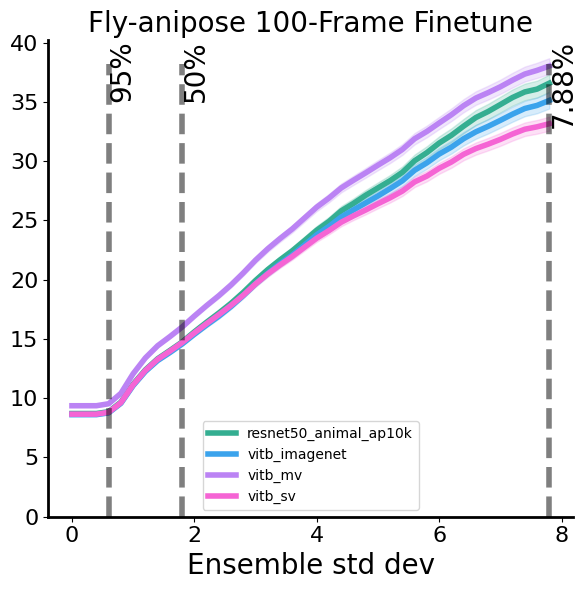

In [7]:
views = ['Cam-A', 'Cam-B', 'Cam-C', 'Cam-D', 'Cam-E', 'Cam-F']
ens = Ensemble()
ens.data_to_plot = {
    # ----------------------
    # resnet50_animal_ap10k
    # ----------------------
    'resnet50_animal_ap10k.0': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-0',
    'resnet50_animal_ap10k.1': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-1',
    'resnet50_animal_ap10k.2': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-2',
    # ----------------------
    # vitb_imagenet
    # ----------------------
    'vitb_imagenet.0': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-vitb_imagenet_frame-100_epoch-300_seed-0',
    'vitb_imagenet.1': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-vitb_imagenet_frame-100_epoch-300_seed-1',
    'vitb_imagenet.2': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-vitb_imagenet_frame-100_epoch-300_seed-2',
    # ----------------------
    # vitb_sv
    # ----------------------
    'vitb_sv.0': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-vitb-sv_frame-100_epoch-300_seed-0',
    'vitb_sv.1': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-vitb-sv_frame-100_epoch-300_seed-1',
    'vitb_sv.2': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-vitb-sv_frame-100_epoch-300_seed-2',
    # ----------------------
    # vitb_mv
    # ----------------------
    'vitb_mv.0': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-vitb-mv_frame-100_epoch-300_seed-0',
    'vitb_mv.1': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-vitb-mv_frame-100_epoch-300_seed-1',
    'vitb_mv.2': f'{LITPOSE_SAVE_DIR}/ds-fly-anipose_mode-ft_model-vitb-mv_frame-100_epoch-300_seed-2',
}
for key, val in ens.data_to_plot.items():
    for view in views:
        ens.data_to_plot[key] = os.path.join(val, f'predictions_{view}_new.csv')

build_ensemble(ens)      

models_to_plot = [
    'resnet50_animal_ap10k',
    'vitb_imagenet',
    'vitb_mv',
    'vitb_sv'
]

def major_model(row_data):
    return '.'.join(row_data.split('.')[:-1])
ens.df_line2['model2'] = ens.df_line2['model'].apply(major_model)

df_line2 = ens.df_line2
n_points_dict = ens.n_points_dict
std_vals = ens.std_vals

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))

for model in models_to_plot:
    data = df_line2[df_line2['model2'] == model]
    sns.lineplot(x='ens-std', y='pixel_error', data=data, label=model, 
                 color=color_mapping[model], ax=ax, errorbar='se', linewidth=line_width)

ax.set_title('Fly-anipose 100-Frame Finetune', fontsize=title_fontsize)
# ax.set_ylabel('Pixel error', fontsize=labels_fontsize)
ax.set_xlabel('Ensemble std dev', fontsize=labels_fontsize)
ax.set_ylim(bottom=0)  # Ensure y-axis starts at 0
ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

# Customize legend
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
# Turn off legend
# ax.legend().remove()
ax.set_ylabel('')
# Plot annotations
percentiles = [95, 50, 5]
vals, prctiles = compute_percentiles(
    arr=n_points_dict[models_to_plot[0] + '.0'],
    std_vals=std_vals,
    percentiles=percentiles,
)

for p, v in zip(prctiles, vals):
    ax.axvline(v, ymax=0.95, linestyle='--', linewidth=line_width, color='black', alpha=0.5)
    ax.text(v, ax.get_ylim()[1], f'{p}%', ha='left', va='top', fontsize=labels_fontsize, rotation=90)

# set spines width
for spine in ax.spines.values():
    spine.set_linewidth(spines_width)

# set right and top spines invisible
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
# plt.grid(True, alpha=0.3)
plt.show()
